# 第四章 查询扩展 Query Expansion

## 目录
- [4.1 - Expansion with generator answers（生成器答案扩展）](#41-expansion-with-generator-answers生成器答案扩展)
- [4.2 - Expansion with multiple queries（多个查询的查询扩展）](#42-expansion-with-multiple-queries多个查询的查询扩展)
- [4.3 - 总结](#43-总结)

我们将通过Expansion with generator answers和Expansion with multiple queries两个例子，学习使用查询增强的方法，来帮助我们改善查询的质量，提供更加精确和丰富的信息。

## 4.1  Expansion with generator answers（生成器答案扩展）


![Expansion with generated answers.png](./images/Expansion%20with%20generated%20answers.png)

我们通过图片了解 Expansion with generator answers 的工作原理：

第一步，我们需要先提出一个查询。

第二步，使用LLM生成问题的答案，以提供相关上下文。

第三步，利用向量数据库（VectorDB）检索原始查询的多个结果，包含附加的上下文。

第四步，再次使用LLM得到最终答案。

让我们开始进行实践。

首先，我们导入要用到的数据。

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='./data/2024年北京市政府工作报告.pdf', \
                                collection_name='beijing_annual_report_2024', \
                                embedding_function=embedding_function,
                                langcode='zh')  # 注意中文文档将langcode改为'zh'
chroma_collection.count()

1028

配置`OPENAI_API_KEY`(在`.env`文件中进行设置)。

In [2]:
import os
import openai
from openai import OpenAI
from dotenv import load_dotenv, find_dotenv

loaded = load_dotenv(find_dotenv(), override=True)
# 从环境变量中获取 OpenAI API Key 或者直接赋值
API_KEY = os.getenv("API_KEY")

# 如果您使用的是官方 API，就直接用 https://api.siliconflow.cn/v1 就行。
BASE_URL = "https://api.siliconflow.cn/v1"

openai_client = OpenAI(api_key=API_KEY, base_url=BASE_URL, max_retries=3)

使用`umap`进行投影数据。

In [3]:
import umap.umap_ as umap
import warnings

# 忽略 FutureWarning 类型的警告
warnings.filterwarnings("ignore", category=FutureWarning)

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0, n_jobs=1).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:08<00:00, 121.09it/s]


参考paper https://arxiv.org/abs/2305.03653

我们创建名为`augment`的函数，进行生成查询，并传递一个查询，传入模型参数（默认使用`gpt-3.5-turbo`）。

In [4]:
def augment_query_generated(query, model="Qwen/Qwen3-8B"):

    extra_body = {}
    if "Qwen3" in model:
        extra_body={
            "enable_thinking": False
        }
    
    messages = [
        {
            "role": "system",
            # 设定一个对话场景，模型被告知扮演一个专业的财经研究助理。
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. " # 系统提示
        },
        {"role": "user", "content": query} # 通过查询作为内容
    ] 
    
    # 定义如何提示模型
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        extra_body=extra_body
    )
    content = response.choices[0].message.content
    return content

进行第一次查询。

In [5]:
original_query = "推动北京财政收入增长的因素是什么?"
# 生成假设答案
hypothetical_answer = augment_query_generated(original_query)
# 联合查询
joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

推动北京财政收入增长的因素是什么? 推动北京财政收入增长的因素主要包括以下几个方面：

1.
**经济持续增长**：北京作为中国的首都和经济中心之一，拥有强大的科技创新能力、高端制造业和现代服务业，经济总量稳步提升，带动了税收收入的增长。

2.
**产业结构优化**：近年来，北京积极推进产业结构调整，重点发展高新技术产业、数字经济、生物医药、人工智能等战略性新兴产业，提升了财政收入的质量
持续性。

3.
**固定资产投资增加**：随着重大基础设施项目建设的推进，如轨道交通、城市副中心、冬奥会场馆等，固定资产投资保持较高增长，带动了相关税收收入。

4. **房地产市场活跃**：尽管近年来政策调控趋严，但北京的房地产市场仍保持相对稳定，土地出让金和相关税费对财政收入贡献较大。

5.
**企业盈利状况良好**：北京拥有大量优质企业和总部机构，特别是在金融、科技、教育等领域，企业盈利能力增强，税源扩大，财政收入随之增长。

6.
**政策支持和财政管理效率提升**：政府通过优化财政支出结构、加强财政管理、提高财政资金使用效率，增强了财政可持续性，同时通过税收优惠政策、吸引
资等措施进一步促进收入增长。

7.
**人口与人才集聚效应**：北京作为全国政治、文化、教育和科研中心，吸引了大量高素质人才和人口流入，推动了消费和投资活动，进而促进了财政收入的增
。

以上因素共同作用，为北京财政收入的稳定增长提供了有力支撑，同时为城市高质量发展提供了重要保障。


发送一个查询和假设作为查询响应我们的检索系统。

我们接下来使用Chroma进行查询。

In [6]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

加快在政务、医疗、教育、工业、
生活服务等领域应用

高标准做好
第三批全国法治政府建设示范创建工作

优
化提升中央政务环境和城市发展品质

在今年的工作中要着重把握好以下几个方面：一
是更加注重服务大局、主动作为

新形势、新任务对政府自身建设提出了更高要求



将查询结果集的嵌入，原始检索的嵌入，联合查询的嵌入进行投影。


In [7]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 217.37it/s]


进行可视化。

(np.float64(-5.822046995162964),
 np.float64(9.59619688987732),
 np.float64(-5.638945913314819),
 np.float64(8.720281934738159))

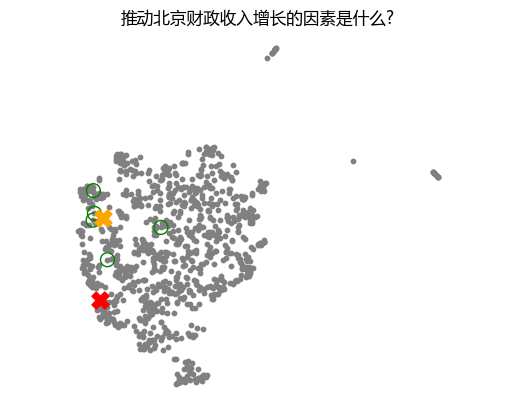

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置全局字体为微软雅黑，显示中文
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

我们可以看到红色的`X`是我们的原始查询，橙色的`X`是我们带有假设答案的查询，绿色的圆圈是我们检索到的查询，可以看出，进行联合查询提高了我们的查询结果。

## 4.2 Expansion with multiple queries（多个查询的查询扩展）

![Expansion with multiple queries.png](./images/Expansion%20with%20multiple%20queries.png)

我们通过图片了解 Expansion with multiple queries 的工作原理：

第一步，我们需要发起一个查询。

第二步，使用大型语言模型（LLM）来生成额外的查询。

第三步，这些新生成的查询被发送到向量数据库（VectorDB）。

第四步，向量数据库检索与原始查询和新查询都相关的结果。

第五步，所有的查询结果被发送回LLM。

第六步，LLM基于所有检索到的信息提供最终的答案。

与上一个方法相同（需要增加更多的系统提示）。

In [9]:
def augment_multiple_query(query, model="Qwen/Qwen3-8B"):

    extra_body = {}
    if "Qwen3" in model:
        extra_body={
            "enable_thinking": False
        }
    
    messages = [
        {
            "role": "system",
            # 为模型提供指令，告诉它扮演一个有用的财经研究助理。
            # 指令包括基于提供的查询生成最多五个相关的额外查询问题。
            # 提示模型生成的问题应该简短，不包含复合句，并涵盖主题的不同方面。
            # 要确保问题是完整的，并且与原始查询相关联。
            # 输出格式为每行一个问题，不要对问题编号。
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        extra_body=extra_body
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

第一次查询。

In [10]:
original_query = "推动北京财政收入增长的因素是什么?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

北京财政收入增长的主要来源有哪些？  
北京的税收政策对财政收入有何影响？  
北京在哪些行业或领域实现了收入快速增长？  
北京财政收入增长是否受到人口因素的影响？  
北京的经济增长与财政收入增长之间有何关系？


我们可以看到LLM生成的其他增强查询问题。


接下来，我们进行构建查询集，使用Chroma并行处理多个查询（原始查询加增强查询）并打印了每个查询及其检索到的文档。

In [11]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# 对检索到的文档进行重复数据删除
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: 推动北京财政收入增长的因素是什么?

Results:
用好“京策”平台向企业精准提供政策服务

是中共北京市委带领全市人民攻坚克难、艰苦奋斗的结果

优
化提升中央政务环境和城市发展品质

严格落实政府系统
机构改革任务

完善疏解激励约束政策体系

----------------------------------------------------------------------------------------------------
Query: 北京财政收入增长的主要来源有哪些？  

Results:
是中共北京市委带领全市人民攻坚克难、艰苦奋斗的结果

用好“京策”平台向企业精准提供政策服务

北京成为国家首批制度型开放试点

全面构建亲清政商关系

完成全国首例地方政府专项债券提前偿还试点

----------------------------------------------------------------------------------------------------
Query: 北京的税收政策对财政收入有何影响？  

Results:
用好“京策”平台向企业精准提供政策服务

是中共北京市委带领全市人民攻坚克难、艰苦奋斗的结果

落实积极就业政策

优化调整购房政策

加快政府职能转变

----------------------------------------------------------------------------------------------------
Query: 北京在哪些行业或领域实现了收入快速增长？  

Results:
北京首列直达欧洲的中欧班列成功开行

启动北京市重点实验室重组

打造营商环境“北京服务”品牌

制定实施“北京服务”意见和促进民营经济发展壮大行动方案

支持北京证券交易所深化改革和高质
量发展

----------------------------------------------------------------------------------------------------
Query: 北京财政收入增长是否受到人口因素的影响？  

Results:
是中共北京市委带领全市人民攻坚克难、艰苦奋斗的结果

用好“京

计算原始查询和增强查询的嵌入，然后使用`umap`将这些嵌入进行绘制投影。

In [12]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 217.41it/s]


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


从查询结果中提取嵌入向量，使用`umap`将这些嵌入进行绘制投影。

In [13]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 226.18it/s]


进行数据可视化。

(np.float64(-5.822046995162964),
 np.float64(9.59619688987732),
 np.float64(-5.638945913314819),
 np.float64(8.720281934738159))

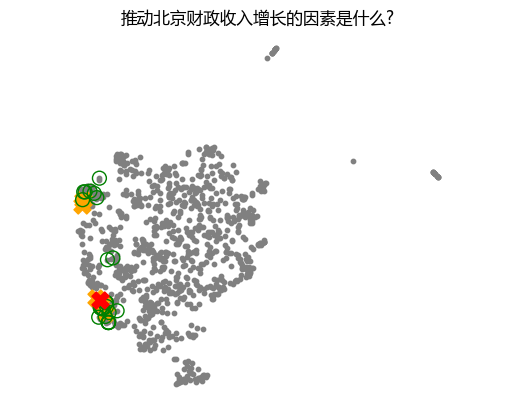

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置全局字体为微软雅黑，显示中文
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

可以看到红色的`X`是我们的原始查询，橙色的`X`是嵌入增强的LLM生成的新查询，绿色的圆圈代表我们实际返回的结果。

## 4.3 总结

通过本次Expansion with generator answers和Expansion with multiple queries两个例子，使用Chroma进行检索的增强，这对于我们找到有效的信息是非常好的。